# EXERCISE 6.2: Crop Yield Estimatoin using Deep Learning

---

**Google Earth Engine**

In this exercise, we will use data extracted from the popular EO Google Earth Engine (GEE) to access do crop yield estimation using the popular Deep Learning Library Pytorch. We will see how to

1. Create a CNN model in Pytorch
2. Train a Pytorch Model
2. Evaluate a Pytorch model



In [ ]:
!pip install geemap

## Setup
Before working on this Exercise setup a GCP project with GEE and Google Drive APIs enabled by following the instructions given at https://docs.google.com/document/d/13SKLn_mqhlaRc1gElr4kmBrkw6KZPeqDDW3AjcTr8YY/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import ee
import time
import sys
import numpy as np
import pandas as pd
import itertools
import os
import traceback
import urllib
import folium

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.service_account import ServiceAccountCredentials

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
from collections import defaultdict
import geemap

## Setup Your Google Earth Engine Credentials
Upload the `.private-key.json` you created while setting up GEE to the current runtime. Click Files > Upload to Session storage on the left pane in this notebook to upload. <br/>
Replace the service account in the code below with your Google Cloud project service account email. It should be of the format <br/>`<id>@ml4eo-<some_number>.iam.gserviceaccount.com`

In [ ]:
service_account = 'ml4eo-service@ml4eo-383508.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '.private-key.json')
ee.Initialize(credentials)


## <font color=orange>Discussion:</font>
Before we start:
Is crop yield estimation a classification or a regression task? Why?

# Getting the Data
The satellite data we will use is exported from the Moderate Resolution Imaging Spectroradiometer (MODIS) MODIS/MOD09A1 dataset.
The input data we use include remote sensing data on surface reflectance, land surface temperature, and land cover type derived from the MODIS satellite, which are available worldwide.
Specifically, the following datasets are used:


1. **MOD09A1: Surface Reflectance**
    "An estimate of the surface spectral reflectance of Terra MODIS bands 1 through 7".

    Basically, an 'image' of the county as seen from the satellite.

2. **MCD12Q1: Land Cover Type**
    Labels the data according to one of five global land cover classification systems. This is used as a mask, because we only want to consider pixels associated with farmland.
3. **MYD11A2: Aqua/Land Surface Temperature**
    Two more bands which can be used as input data to our models.

The yield data is obtained from the USDA website, which measures soybean yields in bushels per acre. The data can be found at the following [link](https://fusiontables.google.com/data?docid=1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM#rows:id=1).

For this exercise, instead of having you export the satellite data yourself we will give you an exported, and preprocessed data that you can directly use for training. For anyone interested, we will supply a separate notebook that shows how the data was downloaded and preprocessed.


A file named `histogram_all_full.npz` which contains the preprocessed data has been shared with you.
Before you proceed make sure you have added the shared file to your drive by right clicking on it clicking "Add shortcut to drive". If you place it at a different location, ensure the path used below is the right one.

The file `histogram_all_full.npz` contains five fields and 10,876 records.
Here is a description of the five fields.
1. output_image: An array that contains preprocessed satellite data as nine 32x32 images
2. output_locations: An array that contains coordinates of each data point
3. output_yield: An array that contains the yield obtained from the USDA data for each location (data point)
4. output_year: An array that contains the year the yield was obtained at and the satellite data was captured.
5. output_indices: An array that contains a pair of integers that uniquely identify each location.

In [ ]:
# Load the data
with np.load("/content/drive/MyDrive/histogram_all_full.npz") as hist:
    images = hist["output_image"]
    locations = hist["output_locations"]
    yields = hist["output_yield"]
    years = hist["output_year"]
    indices = hist["output_index"]


## Exploring the Dataset
We know that one of the first steps in any ML task is data exploration.
We will inspect trends and distribution of the target variable (yield) using many of the methods you studied in Module 5.


In [ ]:
print(f"Shape of images {images.shape}")
print(f"Shape of locations {locations.shape}")
print(f"Shape of yields {yields.shape}")
print(f"Shape of years {years.shape}")
print(f"Shape of indices {indices.shape}")


Shape of images (10876, 9, 32, 32)
Shape of locations (10876, 2)
Shape of yields (10876,)
Shape of years (10876,)
Shape of indices (10876, 2)


To make the exploration easier let's put the years and yields to a Pandas dataframe. We will leave out the other fields.

In [ ]:
df = pd.DataFrame({'year': years, 'yield': yields,})
df.head()

,year,yield
0,2016,37.2
1,2016,54.4
2,2016,43.7
3,2016,47.7
4,2016,43.5


Let's see how many years of data we have.

In [ ]:
df['year'].unique()

array([2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006,
       2005, 2004, 2003])

## Yield Distribution
Let's see what kind of yield distribution we have for the year 2003.

In [ ]:
# Filter and keep the yield values that belong for the year 2003
yields_2003 = yields[years==2003]

# Compute the mean
mean = yields_2003.mean()

# Compute the mean
median = np.median(yields_2003)

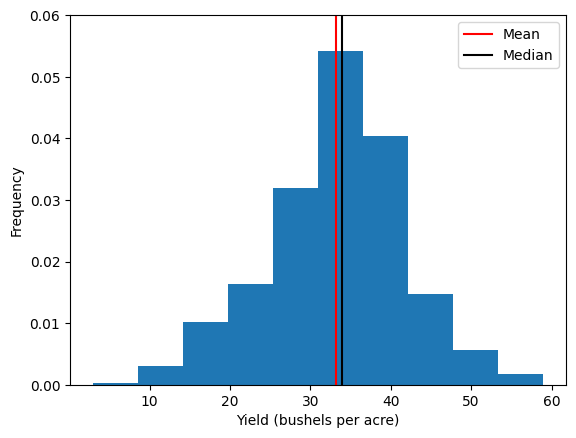

In [ ]:
plt.hist(yields_2003, density=True)
plt.plot([mean, mean], [0, 0.06], 'r')
plt.plot([median, median], [0, 0.06], 'k')
plt.xlabel('Yield (bushels per acre)')
plt.ylabel('Frequency')
plt.ylim([0, 0.06])
plt.legend(['Mean', 'Median'])
plt.show()

## Question 6.2.1
Show the distribution of yield for the year 2011. Indicate the mean and median as vertical lines.

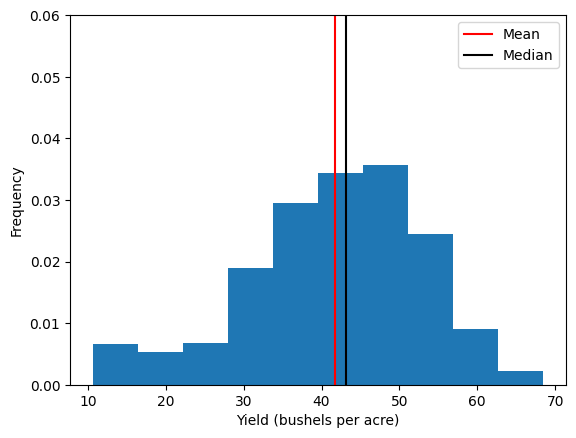

In [ ]:
# Filter and keep the yield values that belong for the year 2003
yields_2011 = yields[years==2011]

# Compute the mean
mean = yields_2011.mean()

# Compute the mean
median = np.median(yields_2011)

plt.hist(yields_2011, density=True)
plt.plot([mean, mean], [0, 0.06], 'r')
plt.plot([median, median], [0, 0.06], 'k')
plt.xlabel('Yield (bushels per acre)')
plt.ylabel('Frequency')
plt.ylim([0, 0.06])
plt.legend(['Mean', 'Median'])
plt.show()

Let's now visualize how the average yield changes through the years 2003 - 2011.

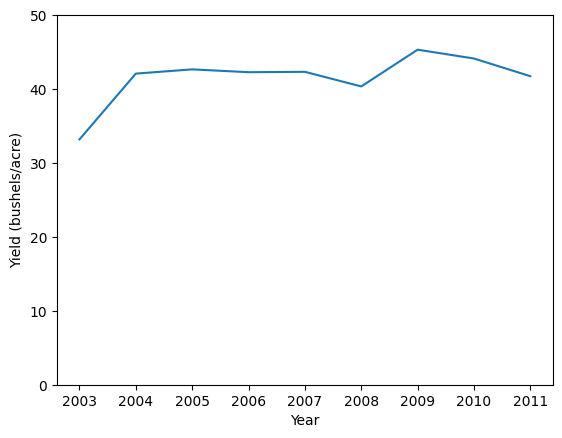

In [ ]:
# Filter the data for years 2003 - 2011 (inclusive)
data_03_11 = df[df['year'] <= 2011]
# Compute the trend of means
means = data_03_11.groupby(by=['year']).mean()
means.reset_index(inplace=True)  # Get rid of multilevel index

plt.plot(means['year'], means['yield'])
plt.xlabel('Year')
plt.ylabel('Yield (bushels/acre)')
plt.ylim([0, 50])
plt.show()


## Discussion
What trend do you see as the year increases?

## Question 6.2.2
Plot the trend of the median yield through the years 2003 - 2011.

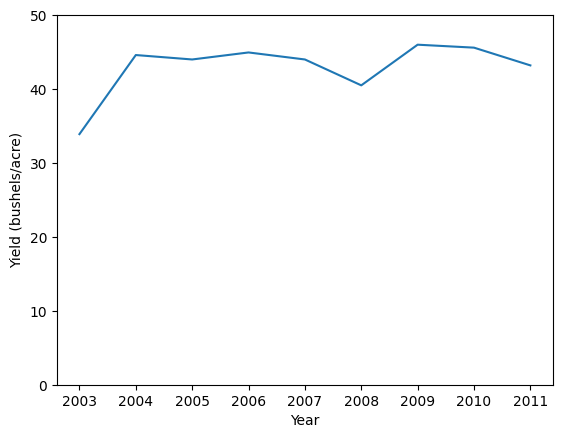

In [ ]:
# Compute the trend of medians
medians = data_03_11.groupby(by=['year']).median()
medians.reset_index(inplace=True)  # Get rid of multilevel index

plt.plot(medians['year'], medians['yield'])
plt.xlabel('Year')
plt.ylabel('Yield (bushels/acre)')
plt.ylim([0, 50])
plt.show()

### Visualize the Yield as a Function of Location
Above we have studied the temporal distribution of yield (how yield changes across time), now let's visualize the spatial distribution of yield (how yield varies over a given area) as a heatmap.

In [ ]:
# Ensure each location is used once in center computation
unique_locations = np.unique(locations, axis=0)

# compute center
center = unique_locations.mean(axis=0)
center = ee.Geometry.Point([center[0], center[1]])
print(center.getInfo())



{'type': 'Point', 'coordinates': [-92.8241780861677, 40.92446041043084]}


Let's visualize the yields for the year 2003 as a heatmap on a GEE map.

In [ ]:
# Filter the locations
locations_2003 = locations[years == 2003]
yields_2003 = yields[years == 2003]

# Convert the set of locations to GEE points
gee_points = [ee.Geometry.Point(float(loc[0]), float(loc[1])) for loc in locations_2003]

# Make a feature collection out of the set of GEE points
points = ee.FeatureCollection(
    [ee.Feature(pt, {'key': f"loc {i}", "yield": yields_2003[i]}) for i, pt in enumerate(gee_points)]
)


Let's write a function that displays the yield as a heatmap.

In [ ]:
def heatmap(points, radius=20):
    ptImg = points.reduceToImage(['yield'], ee.Reducer.first()).unmask(0)
    kernel = ee.Kernel.circle(radius).add(ee.Kernel.gaussian(radius * 2, radius/2))
    result = ptImg.convolve(kernel)
    return result.updateMask(result.neq(0))

In [ ]:
heatmapImg = heatmap(points, 7)

In [ ]:
heatmapVis= {"palette":['lightgreen', 'green', 'yellow', '#880000', 'red']}

map1 = geemap.Map()
map1.centerObject(center, 6)
map1.addLayer(heatmapImg, heatmapVis, "heatmap")
map1.addLayerControl()
map1

Map(center=[40.92446041043084, -92.8241780861677], controls=(WidgetControl(options=['position', 'transparent_b…

To ensure our model has predictive power for future yields we will train the model for all years preceeding a given year and evaluate it on the given year.

In [ ]:
# Choose years for evaluation
pred_years = range(2012, 2016)


Since we will be using deep neural networks for this task it is better if we train and evaluate on a GPU. Colaboratory contains

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


## Image Standardization
We will whiten all images by ensuring the mean of the images is zero. The following function does that.

The mean is computed on the training images.

In [ ]:
def normalize_images(train_images, val_images):
    mean = np.mean(train_images, axis=(0, 2, 3))

    train_images = (train_images.transpose(0, 2, 3, 1) - mean).transpose(0, 3, 1, 2)
    val_images = (val_images.transpose(0, 2, 3, 1) - mean).transpose(0, 3, 1, 2)

    return train_images, val_images

## Deep Learning with Pytorch
PyTorch is an open source machine learning framework that allows you to write your own neural networks and optimize them efficiently. However, PyTorch is not the only framework of its kind. Alternatives to PyTorch include TensorFlow, JAX and Caffe.

Pytorch is well established, has a huge developer community (originally developed by Facebook), is very flexible and especially used in research. Many current papers publish their code in PyTorch, and thus it is good to be familiar with PyTorch as well. Meanwhile, TensorFlow (developed by Google) is usually known for being a production-grade deep learning library. Still, if you know one machine learning framework in depth, it is very easy to learn another one because many of them use the same concepts and ideas. For instance, TensorFlow’s version 2 was heavily inspired by the most popular features of PyTorch, making the frameworks even more similar.

### Training Neural Networks
A typical training procedure for a neural network is as follows:
<ul class="simple">
<li><p>Define the neural network that has some learnable parameters (or
weights)</p></li>
<li><p>Iterate over a dataset of inputs</p></li>
<li><p>Process input through the network</p></li>
<li><p>Compute the loss (how far is the output from being correct)</p></li>
<li><p>Propagate gradients back into the network’s parameters</p></li>
<li><p>Update the weights of the network, typically using a simple update rule:
<code class="docutils literal notranslate"><span class="pre">weight</span> <span class="pre">=</span> <span class="pre">weight</span> <span class="pre">-</span> <span class="pre">learning_rate</span> <span class="pre">*</span> <span class="pre">gradient</span></code></p></li>
</ul>
In Pytorch, the different the steps above are accomplished by instantiating the following classes:
<ul class="simple">
<li><p>Define the neural network that has some learnable parameters (or
weights)----> Create a sub-class of `torch.nn.Module`</p></li>
<li><p>Iterate over a dataset of inputs ---> `torch.utils.data.Dataset` and `torch.utils.data.Dataloader`</p></li>
<li><p>Process input through the network---> calling the `forward` method of the `torch.nn.Module` sub-class you instantiated</p></li>
<li><p>Compute the loss (how far is the output from being correct) ---> Creating an instance of `torch.nn.Module` and passing the outputs of your model and labels to it</p></li>
<li><p>Propagate gradients back into the network’s parameters---> Calling the `backward` method on the loss computed by the step above </p></li>
<li><p>Update the weights of the network, typically using a simple update rule:---> Calling the `step` method on a sub-class of `torch.optim.Optimizer` you instantiated
</ul>

It is all right if some of the steps above are unclear as we will explore them.

## The Neural Network Model
We will use a Convolutional Neural Network for this problem.

A Convolutional Neural Netowrk (CNN) is a Deep Learning algorithm that can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms.

The CNN we will use is based on the paper https://cs.stanford.edu/~ermon/papers/cropyield_AAAI17.pdf

This is what the model looks like.

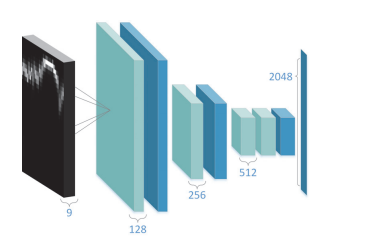

In the next section we provide a class called `Conv2dSamePadding` which is a utility class that allows as to have CNN layers that return output that has the same size as the input. For example if a 32x32 image is fed to a given `Conv2dSamePadding` layer the output will also have a dimension of 32x32.

In [ ]:
class Conv2dSamePadding(nn.Conv2d):
    def forward(self, input):
        return convding(nn.Conv2d)
    def forward(self, input):
        return conv2d_same_padding(
            input, self.weight, self.bias, self.stride, self.dilation, self.groups
        )


def conv2d_same_padding(input, weight, bias=None, stride=1, dilation=1, groups=1):
    # stride and dilation are expected to be tuples.

    # first, we'll figure out how much padding is necessary for the rows
    input_rows = input.size(2)
    filter_rows = weight.size(2)
    effective_filter_size_rows = (filter_rows - 1) * dilation[0] + 1
    out_rows = (input_rows + stride[0] - 1) // stride[0]
    padding_rows = max(
        0, (out_rows - 1) * stride[0] + effective_filter_size_rows - input_rows
    )
    rows_odd = padding_rows % 2 != 0

    # same for columns
    input_cols = input.size(3)
    filter_cols = weight.size(3)
    effective_filter_size_cols = (filter_cols - 1) * dilation[1] + 1
    out_cols = (input_cols + stride[1] - 1) // stride[1]
    padding_cols = max(
        0, (out_cols - 1) * stride[1] + effective_filter_size_cols - input_cols
    )
    cols_odd = padding_cols % 2 != 0

    if rows_odd or cols_odd:
        input = F.pad(input, [0, int(cols_odd), 0, int(rows_odd)])

    return F.conv2d(
        input,
        weight,
        bias,
        stride,
        padding=(padding_rows // 2, padding_cols // 2),
        dilation=dilation,
        groups=groups,
)

### Define the Model
The following class contains 8 layers (5 convolutional layers + 2 Linear layers). Each convolutional layer is followed by a batch normalization unit, a Rectified Linear Unit, and a dropout.

This network takes an image with a dimension of 32x32, and 9 channels. That is, the expected input is 9x32x32. Note that Pytorch Conv2d expects the channels to be the first axis by default.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layer 1
        self.conv1 = Conv2dSamePadding(9, 128, kernel_size=(3, 3), stride=(1, 1))
        self.bn1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.5, inplace=False)

        # Define layer 2
        self.conv2 = Conv2dSamePadding(128, 256, kernel_size=(3, 3), stride=(2, 2))
        self.bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.5, inplace=False)

        # Define layer 3
        self.conv3 = Conv2dSamePadding(256, 256, kernel_size=(3, 3), stride=(1, 1))
        self.bn3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.5, inplace=False)

        # Define layer 4
        self.conv4 = Conv2dSamePadding(256, 512, kernel_size=(3, 3), stride=(2, 2))
        self.bn4 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(p=0.5, inplace=False)

        # Define layer 5
        self.conv5 = Conv2dSamePadding(512, 512, kernel_size=(3, 3), stride=(1, 1))
        self.bn5 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu5 = nn.ReLU()
        self.drop5 = nn.Dropout(p=0.5, inplace=False)

        # Define layer 6
        self.conv6 = Conv2dSamePadding(512, 512, kernel_size=(3, 3), stride=(2, 2))
        self.bn6 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu6 = nn.ReLU()
        self.drop6 = nn.Dropout(p=0.5, inplace=False)

        self.fc1 = nn.Linear(in_features=8192, out_features=2048, bias=True)
        self.relu7 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=2048, out_features=1, bias=True)

    def forward(self, x):
        x = self.drop1(self.relu1(self.bn1(self.conv1(x))))
        x = self.drop2(self.relu2(self.bn2(self.conv2(x))))
        x = self.drop3(self.relu3(self.bn3(self.conv3(x))))
        x = self.drop4(self.relu4(self.bn4(self.conv4(x))))
        x = self.drop5(self.relu5(self.bn5(self.conv5(x))))
        x = self.drop6(self.relu6(self.bn6(self.conv6(x))))

        x = x.view(x.shape[0], -1)

        x = self.relu7(self.fc1(x))
        x = self.fc2(x)
        return x


## Training
In this training loop we randomly split the data into two sets (training and validation), create a data loader, an optimizer, and a loss function. Then, we use the above objects and our model to train it. The function is thouroughly commented please read it to understand what this function is doing.


In [ ]:
def train(model, train_data, train_steps,batch_size, lr):
    # Determine the number of samples we have
    total_size = train_data[0].shape[0]
    # Use 10% of the data for validation
    val_size = total_size // 10
    # Keep the rest for training
    train_size = total_size - val_size

    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(
            TensorDataset(train_data[0], train_data[1]), (train_size, val_size)
    )
    # Create the training data loader
    train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
    )
    # Create the validation data loader
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Create an optimizer that will be used to update the model
    optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
    )
    # Determine how many times the model should see each data point in the training data
    num_epochs = int(train_steps / (total_size / batch_size))
    print(f"Training for {num_epochs} epochs")

    # Instantiate dictionaries to keep scores
    train_scores = defaultdict(list)
    val_scores = defaultdict(list)

    step_number = 0
    min_loss = np.inf

    # Initialize a variable to save the best weights (weights that give the best results)
    best_state = model.state_dict()

    # Define a new loss function (MSE Loss is widely used for regression tasks)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        # Switch the model to training mode
        model.train()

        # running train and val scores are only for printing out
        # information
        running_train_scores = defaultdict(list)

        # Iterate over the dataset
        for train_x, train_y in tqdm(train_dataloader):
            # Clear the previous gradients accumulated from the model
            optimizer.zero_grad()

            # Pass the training data to the model
            pred_y = model(train_x.to(device))

            # Compute the loss
            loss = criterion(pred_y, train_y.to(device))

            # Propagate gradients through the network
            loss.backward()

            # Update the weights
            optimizer.step()

            # Keep the scores
            train_scores["loss"].append(loss.item())

            step_number += 1

            # Decrease the learning rate after 4000 and 20000 steps
            if step_number in [4000, 20000]:
                for param_group in optimizer.param_groups:
                    param_group["lr"] /= 10

        train_output_strings = []
        for key, val in running_train_scores.items():
            train_output_strings.append(
                "{}: {}".format(key, round(np.array(val).mean(), 5))
            )

        running_val_scores = defaultdict(list)
        # Switch the model to evaluation mode
        model.eval()

        with torch.no_grad():
            # Iterate over the validation dataset
            for (val_x, val_y) in tqdm(val_dataloader):
                # Pass the validation sample to the model
                val_pred_y = model(val_x.to(device))

                # Compute the loss
                val_loss = criterion(val_pred_y, val_y.to(device))

                # Save the computed loss
                val_scores["loss"].append(val_loss.item())

        val_output_strings = []
        for key, val in running_val_scores.items():
            val_output_strings.append(
                "{}: {}".format(key, round(np.array(val).mean(), 5))
            )

        print("TRAINING: {}".format(", ".join(train_output_strings)))
        print("VALIDATION: {}".format(", ".join(val_output_strings)))

        # Compute the mean validation loss (over the validation samples)
        epoch_val_loss = np.array(running_val_scores["loss"]).mean()

        # If the validation loss is smaller than the historic minimum save the current weights as the best weights
        if epoch_val_loss < min_loss:
            best_state = model.state_dict()
            min_loss = epoch_val_loss
    # Return the best model
    model.load_state_dict(best_state)
    return train_scores, val_scores

### Evaluation
Now that we have training function let's write a function that evaluates the model on the training set and the test set. This function will iterate over the training and test datasets to compute the output of each sample in each set. Read the comments to understand what the function is doing.

In [ ]:
def predict(model, train_data, test_data, batch_size):
    train_images, train_yields, train_locations, train_indices, train_years = train_data

    # Create a dataset of training samples
    train_dataset = TensorDataset(
        train_images, train_yields, train_locations, train_indices, train_years
    )

    test_images, test_yields, test_locations, test_indices, test_years = test_data

    # Create a dataset of test samples
    test_dataset = TensorDataset(
        test_images, test_yields, test_locations, test_indices, test_years
    )

    # Create a train and test data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    results = defaultdict(list)

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        # Iterate over the training dataset
        for train_im, train_yield, train_loc, train_idx, train_year in tqdm(
            train_dataloader):
            # Pass the sample to the model and compute the output
            model_output = model(train_im.to(device))
            pred = model_output

            # Save the results
            results["train_pred"].extend(pred.squeeze(1).tolist())
            results["train_real"].extend(train_yield.squeeze(1).tolist())
            results["train_loc"].append(train_loc.numpy())
            results["train_indices"].append(train_idx.numpy())
            results["train_years"].extend(train_year.tolist())

        # Iterate over the test dataset
        for test_im, test_yield, test_loc, test_idx, test_year in tqdm(
            test_dataloader
        ):
            # Compute the output
            model_output = model(test_im.to(device))
            pred = model_output

            # Save the output
            results["test_pred"].extend(pred.squeeze(1).tolist())
            results["test_real"].extend(test_yield.squeeze(1).tolist())
            results["test_loc"].append(test_loc.numpy())
            results["test_indices"].append(test_idx.numpy())
            results["test_years"].extend(test_year.tolist())

    for key in results:
        if key in [
            "train_feat",
            "test_feat",
            "train_loc",
            "test_loc",
            "train_indices",
            "test_indices",
            "test_pred",
            "test_real",
        ]:
            results[key] = np.array(results[key])

    return results

## Running the Training and Evaluation
Let's say we want to predict the yield for the year 2012. What we should do is train on data available for the years 2003 - 2011 and evaluate the model on the data for the year 2012. That way we can ensure we have trained a causal model (a model that has predictive power without seeing future data).

In [ ]:
def run_one_year(model, predict_year, time, train_steps, batch_size, lr):
    # Use the data for years precedding `predict_year` as training data
    train_idx = np.nonzero(years < predict_year)[0]
    # Use the data for the year `predict_year` as evaluation (testing) data
    test_idx = np.nonzero(years == predict_year)[0]

    train_images, test_images = normalize_images(images[train_idx],
                                                  images[test_idx])

    # Return a training data tuple containing images, yields, locations, indices, and years
    train_data = (
        torch.as_tensor(
                    train_images[:, :, :time, :], device=device
                ).float(),
        torch.as_tensor(yields[train_idx], device=device).float().unsqueeze(1),
        torch.as_tensor(locations[train_idx]),
        torch.as_tensor(indices[train_idx]),
        torch.as_tensor(years[train_idx]),
    )

    # Return a test data tuple containing images, yields, locations, indices, and years
    test_data = (
            torch.as_tensor(
                test_images[:, :, :time, :], device=device
            ).float(),
            torch.as_tensor(yields[test_idx], device=device).float().unsqueeze(1),
            torch.as_tensor(locations[test_idx]),
            torch.as_tensor(indices[test_idx]),
            torch.as_tensor(years[test_idx]),
    )

    # Call the training function to train the model
    train_scores, val_scores = train(model, train_data, train_steps, batch_size, lr)

    # Call the evaluation function to evaluate the model on train and test sets
    results = predict(model, train_data, test_data, batch_size)

    model_information = {
            "state_dict": model.state_dict(),
            "val_loss": val_scores["loss"],
            "train_loss": train_scores["loss"],
    }
    for key in results:
        model_information[key] = results[key]

    true, pred =  model_information["test_real"], model_information["test_pred"]

    # Compute the RMSE and ME
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    me = np.mean(true - pred)

    return rmse, me

## Running the Training/Evaluation
We will now use the following function that uses the functions above to run the entire process of training.

This function run training and evaluation of the model for each year in the variable `pred_years` defined above.

In [ ]:
def run(model, batch_size=32, learning_rate=1e-3, weight_decay=0,
        train_steps=2500):
    years_list, run_numbers, rmse_list, me_list, times_list = [], [], [], [], []
    times = [32]
    for pred_year in pred_years:
        for time in times:
            results = run_one_year(model, pred_year, time, train_steps,
                                   batch_size,learning_rate)
            years_list.append(pred_year)
            times_list.append(time)
            rmse, me = results
            rmse_list.append(rmse)
            me_list.append(me)
    data = {
        "year": years_list,
        "time_idx": times_list,
        "RMSE": rmse_list,
        "ME": me_list,
    }
    results_df = pd.DataFrame(data=data)
    results_df.to_csv("results.csv")

In [ ]:
model = ConvNet()
model.to(device)
model

ConvNet(
  (conv1): Conv2dSamePadding(9, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2dSamePadding(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2dSamePadding(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2dSamePadding(256, 512, kernel_size=(3, 3), stride=(2, 2))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (drop4): Dropout(p=0.5, inplace=False)
  (conv5): Conv2dSamePadding(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(512, e

### Sanity Check
To ensure our model works as expected let's pass one of the images as tensor input and examine the output.

In [ ]:
tensor_input = torch.as_tensor(images[0]).unsqueeze(0).float().to(device)
print("Input shape is:", tensor_input.shape)
out = model(tensor_input)

print("Output is: ", out)

Input shape is: torch.Size([1, 9, 32, 32])
Output is:  tensor([[-0.0516]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Question 6.2.
Pass the model an image of zeros and print the output you get.
Don't remove the `torch.seed(42)` write your solution under this line.

In [ ]:
torch.manual_seed(42)

# Answer
tensor_input = torch.zeros(1, 9, 32, 32).to(device)
out = model(tensor_input)

print("Output is: ", out)

Output is:  tensor([[0.0259]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Question 6.2.
1. Run the cell above 5 times and log the result you get for the five runs.
2. Comment out the line `torch.manual_seed(42)`, run the cell above 5 times, and log the results for the five runs.

## <font color=orange>Discussion:</font>
What did you observe from the above results?

## Run Training and Validation

Let's now run the model.

In [ ]:
run(model, train_steps=25000)

Training for 0 epochs


100%|██████████| 25/25 [00:00<00:00, 133.06it/s]


Training for 0 epochs


100%|██████████| 23/23 [00:00<00:00, 128.76it/s]


Training for 0 epochs


100%|██████████| 24/24 [00:00<00:00, 129.90it/s]


Training for 0 epochs


100%|██████████| 22/22 [00:00<00:00, 123.17it/s]


# Checking the Results
Let's now load and inspect the results

In [ ]:
df = pd.read_csv('results.csv')
df

,Unnamed: 0,year,time_idx,RMSE,ME
0,0,2012,32,40.044902,38.493199
1,1,2013,32,45.297923,44.352797
2,2,2014,32,48.843601,47.948785
3,3,2015,32,50.149616,49.243231


## Question 6.2.4
For which year did you get the best results? What was the value? Can you explain the results? Submit your Pandas Dataframe.

## Question 6.2.5
Run the model or 100,000 steps and submit your results dataframe.